#**Atari Env Wrappers for NN Explained**
The basic gym wrappers are great, but they are not enough to make the interface with the game environment convinate to use in the training process. Therefore, we have this following code with additional environment wrappers.


IMPORTS

In [ ]:
# @title
########################## IMPORTS #########################################
%pip install -U ale_py==0.8.0
%pip install gym[atari,accept-rom-license]
%pip install gymnasium
import numpy as np
import gymnasium
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit #, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os

import matplotlib
matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
import copy
!apt-get install -y python-opengl ffmpeg
%pip install pyvirtualdisplay
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers.record_video import RecordVideo
from IPython.display import display, HTML
from IPython.display import clear_output
import io
import base64
%pip install 'shimmy>=0.2.1'
from gym.spaces import Discrete
from torch.distributions.categorical import Categorical
from collections import deque
from gym import spaces
cv2.ocl.setUseOpenCL(False)

device = torch.device("cpu")

In [ ]:
# @title
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the GPU")

else:
    device = torch.device("cpu")

**wrap_atari**: First wrap.

it's simply a function that wraps the env with the two other wrappers
*   NoopResetEnv
*   MaxAndSkipEnv



In [3]:
def wrap_atari(env, max_episode_steps=None):
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)

    assert max_episode_steps is None

    return env

class **NoopResetEnv**:

In summary, this wrapper adds a random number of no-op actions at the beginning of each episode during the reset phase. The purpose of this is to introduce variability in the initial states the agent encounters.

In [20]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        #self.render_mode = 'human'
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In the **MaxAndSkipEnv** wrapper, the max_frame is the result of applying max pooling across the last two observations stored in the self._obs_buffer. Specifically, it's the element-wise maximum value for each pixel/channel position between the two frames.

 MaxAndSkipEnv wrapper, this max_frame represents a downsampled observation that captures the maximum values from the last two frames. It's a way of summarizing information from multiple consecutive frames to reduce temporal resolution and speed up learning.

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

The **wrap_deepmind** function is a configuration utility for creating a DeepMind-style Atari environment. It takes an environment and applies a series of wrappers based on the specified options.

In [6]:
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

class **EpisodicLifeEnv**

This wrapper is designed to make the end of life equivalent to the end of an episode, but it only resets on a true game over, following the practice used by DeepMind for DQN and similar algorithms.

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class **FireResetEnv**

The purpose of this wrapper is to handle environments where the game is fixed until the agent takes a 'FIRE' action. After resetting the environment, it takes two additional steps to ensure that the game is in a valid state for the agent to start interacting.

This kind of wrapper is useful when working with specific Atari environments where a 'FIRE' action is required to start the game or initiate a new episode.

In [8]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class **WarpFrame**


The WarpFrame class is an observation wrapper for Gym environments. Its purpose is to warp frames to a specified size (**84x84**, as done in the Nature paper) and possibly convert them to **grayscale**. If the environment uses dictionary observations, it allows you to specify a key indicating which observation should be warped.

In [9]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class **ScaledFloatFrame**

This wrapper is often used in reinforcement learning with deep neural networks. Scaling the pixel values to the range [0, 1] can help with numerical stability during training, especially when using activation functions like sigmoid or hyperbolic tangent. It's worth noting the comment in the code mentioning that this operation undoes memory optimization, so it's recommended to use it with smaller replay buffers only. The reason for this caution is that scaling to [0, 1] increases the memory requirements compared to the original uint8 format (0 to 255).

In [10]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0



class **ClipRewardEnv**

The purpose of this wrapper is to simplify the reward signal by converting it to a binary form: -1 for negative rewards, 0 for zero rewards, and +1 for positive rewards. This kind of reward clipping can be beneficial in reinforcement learning to provide a more stable and standardized reward signal for training algorithms. It helps avoid issues related to reward scaling and can make learning more robust. However, it may also discard fine-grained information about the magnitude of rewards, so it's a trade-off depending on the specific requirements of the learning task.

In [11]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class **FrameStack**

The purpose of this wrapper is to provide the agent with temporal information by stacking the last k frames. This can help the agent capture motion and dynamics in the environment, allowing it to make more informed decisions based on recent history. The use of LazyFrames makes the implementation optimized for memory efficiency.

It maintains a deque (self.frames) to store the last k frames.
It creates a new observation space that represents the stacked frames. The shape is adjusted to include k channels in the last dimension, effectively stacking the frames.


*reset method:*

This method is called when the environment is reset.
It resets the original environment and initializes the deque with the first observation (ob) repeated k times. It returns the stacked observation using the _get_ob method.

*step method:*

This method is called when the agent takes a step in the environment.
It takes the original step and appends the new observation to the deque.
It returns the stacked observation using the _get_ob method.

*_get_ob method:*

This method returns a LazyFrames object that represents the stacked frames. LazyFrames is a more memory-efficient representation.


In [12]:

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class **LazyFrames**

The LazyFrames class is designed to optimize memory usage when dealing with a sequence of frames, which is common in deep reinforcement learning scenarios with large replay buffers. The key idea is to concatenate frames along the last axis only when necessary, allowing shared memory for common frames between consecutive observations.

*force method:*

This method concatenates the frames along the last axis and stores the result in _out.
It is called only when necessary to ensure that common frames are stored only once.
After calling _force, _frames is set to None to free up memory.

*array method:*

This method returns the concatenated frames as a numpy array.
Optionally, it can cast the array to a specified data type (dtype).


In [13]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

class **ImageToPyTorch**

The purpose of this wrapper is to ensure that the image observations are in the format expected by PyTorch. Many deep learning frameworks, including PyTorch, commonly use the (channels, height, width) format for images. This wrapper is useful when working with PyTorch-based models for deep reinforcement learning on Atari environments.

In [14]:

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to channels x weight x height
    """

    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.uint8,
        )

    def observation(self, observation):
        return np.transpose(observation, axes=(2, 0, 1))

def wrap_pytorch(env):
    return ImageToPyTorch(env)

# Reference: https://arxiv.org/pdf/1707.06887.pdf
# https://github.com/ShangtongZhang/DeepRL/blob/master/deep_rl/agent/CategoricalDQN_agent.py


The **image_return_distributions** function is creating a bar plot for probability mass functions (PMFs) and returning an RGB array representation of the plot.
This function is meant to be useful for visualizing probability distributions associated with returns in a reinforcement learning context. The RGB array can be used, for example, to display the distribution in a graphical user interface or save it as an image file.


The **image_q_values** function creates a bar plot for Q-values and return an RGB array representation of the plot.

In [15]:

def image_return_distributions(pmfs, x_length, y_length, dpi=100):
    fig, ax = plt.subplots(figsize=(x_length/dpi,y_length/dpi), constrained_layout=True, dpi=100)
    current_palette = sns.color_palette(n_colors=env.action_space.n)
    df = pd.DataFrame(pmfs.T)
    for idx, y in enumerate(df.columns):
        ax.bar(np.linspace(args.v_min, args.v_max, num=args.n_atoms).astype(np.int), df[y], color=current_palette[idx])
    ax.set(xlabel='return distribution', ylabel='probs')
    fig.canvas.draw()
    X = np.array(fig.canvas.renderer.buffer_rgba())
    return_distribution_rgb_array = np.array(Image.fromarray(X).convert('RGB'))
    plt.close(fig)
    return return_distribution_rgb_array

def image_q_values(q_values, x_length, y_length, dpi=100):
    fig, ax = plt.subplots(figsize=(x_length/dpi,y_length/dpi), constrained_layout=True, dpi=100)
    df = pd.DataFrame(q_values.T)
    sns.barplot(x=df.index, y=0, data=df, ax=ax)
    ax.set(xlabel='actions', ylabel='q-values')
    fig.canvas.draw()
    X = np.array(fig.canvas.renderer.buffer_rgba())
    # Image.fromarray(X)
    q_value_rgb_array = np.array(Image.fromarray(X).convert('RGB'))
    plt.close(fig)
    return q_value_rgb_array



The **QValueAndReturnDistributionVisualizationWrapper** class is a custom wrapper for a Gym environment. It enhances the rendering functionality by visualizing Q-values and return distributions alongside the original environment rendering.

*render method:*

Overrides the render method of the superclass.
If mode is "rgb_array," it performs the following:

Retrieves the original environment rendering (env_rgb_array).
Generates RGB arrays for Q-values (self.q_value_rgb_array) and return distributions (self.return_rgb_array).
Concatenates the visualizations horizontally and vertically and returns the result.

If mode is not "rgb_array," it performs the original rendering without visualization.

In [ ]:
class QValueAndReturnDistributionVisualizationWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)
        self.env.reset()
        self.image_shape = self.env.render(mode="rgb_array").shape
        self.q_values = np.array([[0.,0.,0.,0.]])
        self.return_pmfs = np.zeros((4, 51))
        # self.metadata['video.frames_per_second'] = 60

    def set_q_values(self, q_values):
        #Sets the Q-values for visualization.
        self.q_values = q_values

    def set_return_pmfs(self, return_pmfs):
        #Sets the return probability mass functions (PMFs) for visualization.
        self.return_pmfs = return_pmfs

    def rgb_render(self, mode="rgb_array"):
        env_rgb_array = super().render(mode)
        return env_rgb_array

    def render(self, mode="human"):
        if mode=="rgb_array":
            env_rgb_array = super().render(mode)
            self.q_value_rgb_array = image_q_values(
                self.q_values, self.image_shape[1], self.image_shape[0], dpi=100)
            self.return_rgb_array = image_return_distributions(
                self.return_pmfs, self.image_shape[1]*2, self.image_shape[0], dpi=100)
            return np.append(np.append(
                env_rgb_array,
                self.q_value_rgb_array, axis=1), self.return_rgb_array,
                axis=0)
        else:
            super().render(mode)


**ProbsVisualizationWrapper**

The ProbsVisualizationWrapper is a custom wrapper for an OpenAI Gym environment that adds the ability to visualize probability distributions associated with actions alongside the regular environment rendering.

The render method is modified to support rendering in both "rgb_array" mode and "human" mode.
In "rgb_array" mode, it visualizes the environment and overlays a bar plot of the action probabilities. The resulting RGB array is then concatenated horizontally (axis=1) with the original environment rendering (env_rgb_array).
If mode is not "rgb_array," it calls the superclass's render method for other rendering modes.

This wrapper can be useful for visualizing the action probabilities while interacting with the environment. The visualization includes a bar plot showing the probabilities associated with each action.

In [17]:
class ProbsVisualizationWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env.reset()
        self.image_shape = self.env.render(mode="rgb_array").shape
        self.probs = [[0.,0.,0.,0.]]
        # self.metadata['video.frames_per_second'] = 60

    def set_probs(self, probs):
        self.probs = probs

    def render(self, mode="human"):
        if mode=="rgb_array":
            env_rgb_array = super().render(mode)
            fig, ax = plt.subplots(figsize=(self.image_shape[1]/100,self.image_shape[0]/100), constrained_layout=True, dpi=100)
            df = pd.DataFrame(np.array(self.probs).T)
            sns.barplot(x=df.index, y=0, data=df, ax=ax)
            ax.set(xlabel='actions', ylabel='probs')
            fig.canvas.draw()
            X = np.array(fig.canvas.renderer.buffer_rgba())
            Image.fromarray(X)
            # Image.fromarray(X)
            rgb_image = np.array(Image.fromarray(X).convert('RGB'))
            plt.close(fig)
            q_value_rgb_array = rgb_image
            return np.append(env_rgb_array, q_value_rgb_array, axis=1)
        else:
            super().render(mode)

In [ ]:
def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

# Environment Set Up

Notive the order of wraping to the environment


1.   wrap_atari:

    *   NoopResetEnv(env, noop_max=30)
    *   MaxAndSkipEnv(env, skip=4)


2.   gym.wrappers.RecordEpisodeStatistics
3.   QValueAndReturnDistributionVisualizationWrapper
4.   wrap_pytorch
5.   wrap_deepmind:

    *   EpisodicLifeEnv
    *   FireResetEnv
    *   WarpFrame
    *   ScaledFloatFrame (not used)
    *   ClipRewardEnv
    *   FrameStack (& LazyFrames)

The order of environment wrapping is crucial for the proper override of functions.







In [ ]:
capture_video = True
# TRY NOT TO MODIFY: setup the environment
device = torch.device('cuda' if torch.cuda.is_available() and args.cuda else 'cpu')
env = gym.make("BreakoutNoFrameskip-v4")
env = wrap_atari(env)
env = gym.wrappers.RecordEpisodeStatistics(env) # records episode reward in `info['episode']['r']`
if capture_video:
    env = QValueAndReturnDistributionVisualizationWrapper(env)
env = wrap_pytorch(
    wrap_deepmind(
        env,
        clip_rewards=True,
        frame_stack=True,
        scale=False,
    )
)
# respect the default timelimit
assert isinstance(env.action_space, Discrete), "only discrete action space is supported"


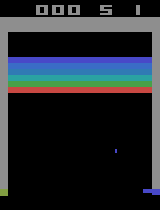

next_obs.shape= (4, 84, 84)
reward= 0.0
done= False


(None, None)

In [31]:
env.reset()
next_obs, reward, done, info  = env.step(0)
rgb_state = env.rgb_render(mode="rgb_array")
cv2_imshow(rgb_state)
print("next_obs.shape=",next_obs.shape)
print("reward=", reward), print("done=", done)